#Deep Learning with Multi-Label Classification for Psychotic Disorder Diseases
Manupriya Arora (manupri2@illinois.edu) and Vraj Patel (vpate33@illinois.edu)

In [ ]:
import os
import math
import keras
import tensorflow as tf 
import random
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation
from google.colab import files
from numpy.random import seed

In [ ]:
# set seed
seed = 59824083
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
# Importing the library
import psutil

!lscpu |grep 'Model name'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Core(s) per socket:  1
Thread(s) per core:  2


##Processing the Original and Balanced Data
The steps taken here are similar to the steps taken in the paper "*Application of deep and machine learning techniques for multi-label classification performance on psychotic disorder diseases*".

We will be loading in both the original data and a modified version of the original data.

For both the datasets, we will apply the following procedure:
1.   Load in the proper data (Provided as public supplementary data from the original paper).
2.   Create one-hot encoding vectors for each of the five target variables we are interested in.

For only the modified data, we will apply the following:
3.   Apply the conventional multiclass SMOTE on the concatenated target variables and categorical feature vectors.

###1. Load in Both of the Datasets


####Loading in the Original Data
Load in the original dataset. This will be the imbalanced dataset that we will use. Make sure to name this `PDD_supplementary_original.csv` in advance.

In [ ]:
if not os.path.isfile("PDD_supplementary_original.csv"):
  print("Upload the modified file name 'PDD_supplementary_original.csv'...")
  if files.upload():
    print("Uploaded!")

In [ ]:
# Load the data in
data_original = pd.read_csv('PDD_supplementary_original.csv')

In [ ]:
# View some of the features of the original file
print(data_original.head())
print("data.shape: ",data_original.shape)
print(data_original.columns)

  sex  age faNoily_status religion occupation genetic status loss_of_parent  \
0   M   18            Yes        C    STUDENT     Yes      S            Yes   
1   F   30            Yes        M    ARTISAN     Yes      S            Yes   
2   M   22            Yes        C    STUDENT      No      S             No   
3   M   35             No        M    ARTISAN      No      M             No   
4   M   30            Yes        M    ARTISAN     Yes      M             No   

  divorse Injury Spiritual_consult  Insominia  shizopherania  vascula_demetia  \
0      No     No               Yes          0              1                1   
1      No    Yes               Yes          1              1                1   
2      No     No               Yes          1              1                1   
3      No     No               Yes          1              1                0   
4      No     No               Yes          1              1                1   

   MBD  Bipolar  agecode  target  
0  

In [ ]:
# We can drop some of the columns that are not explained in the paper
if 'agecode' in data_original.columns:
  data_original = data_original.drop(['agecode'], axis="columns")
# We can now view the data to see what it looks like
data_original

,sex,age,faNoily_status,religion,occupation,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,target
0,M,18,Yes,C,STUDENT,Yes,S,Yes,No,No,Yes,0,1,1,1,0,1110
1,F,30,Yes,M,ARTISAN,Yes,S,Yes,No,Yes,Yes,1,1,1,0,0,11100
2,M,22,Yes,C,STUDENT,No,S,No,No,No,Yes,1,1,1,0,1,11101
3,M,35,No,M,ARTISAN,No,M,No,No,No,Yes,1,1,0,0,1,11001
4,M,30,Yes,M,ARTISAN,Yes,M,No,No,No,Yes,1,1,1,1,1,11111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,F,73,Yes,M,RETIRED,Yes,S,Yes,No,No,Yes,1,0,1,0,1,10101
496,F,50,No,M,ARTISAN,No,M,Yes,No,No,No,1,1,0,1,1,11011
497,F,32,No,C,FORCE,No,M,No,No,No,Yes,0,1,1,1,0,1110
498,M,13,Yes,C,STUDENT,No,S,Yes,No,No,No,0,1,0,0,0,1000


####Extract the Feature and Target Vectors for the Original Dataset
Split the data into feature vectors and target vectors to ease the process of one-hot encoding for both the original data and modified data.

In [ ]:
# The features that we are interested in (Training data)
target_cols = ['Insominia','shizopherania','vascula_demetia','MBD','Bipolar','target'];
features_original = data_original.drop(target_cols, axis='columns')
print("features.shape: ", features_original.shape)
features_original

features.shape:  (500, 11)


,sex,age,faNoily_status,religion,occupation,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult
0,M,18,Yes,C,STUDENT,Yes,S,Yes,No,No,Yes
1,F,30,Yes,M,ARTISAN,Yes,S,Yes,No,Yes,Yes
2,M,22,Yes,C,STUDENT,No,S,No,No,No,Yes
3,M,35,No,M,ARTISAN,No,M,No,No,No,Yes
4,M,30,Yes,M,ARTISAN,Yes,M,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...
495,F,73,Yes,M,RETIRED,Yes,S,Yes,No,No,Yes
496,F,50,No,M,ARTISAN,No,M,Yes,No,No,No
497,F,32,No,C,FORCE,No,M,No,No,No,Yes
498,M,13,Yes,C,STUDENT,No,S,Yes,No,No,No


In [ ]:
# The target columns that we are interested in for the orignial data
targets_original = data_original[target_cols]
print("targets_original.shape: ", targets_original.shape)
targets_original

targets_original.shape:  (500, 6)


,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,target
0,0,1,1,1,0,1110
1,1,1,1,0,0,11100
2,1,1,1,0,1,11101
3,1,1,0,0,1,11001
4,1,1,1,1,1,11111
...,...,...,...,...,...,...
495,1,0,1,0,1,10101
496,1,1,0,1,1,11011
497,0,1,1,1,0,1110
498,0,1,0,0,0,1000


####Loading in the Modifed Data
In order to make it balanced, the paper recommended to remove rows with target combinations that appeared only a few times throughout the data set. Matching the paper, the columns that were identified with less than 6 neighbors included: `11100, 01111, 10011, 00110, 00010, 10100, 10111`. Subsequently, these were the rows that were removed from the data to create the balanced dataset.

Once manual processing is completed, load in the supplementary data. This will eventually hold synthetic data and will become the new balanced dataset that we will use. Make sure the name of file is `PDD_supplementary.csv` for the dataset with removed columns.

In [ ]:
# If the file is not present, add the file
if not os.path.isfile("PDD_supplementary.csv"):
  print("Upload the modified file name 'PDD_supplementary.csv'...")
  if files.upload():
    print("Uploaded!")

In [ ]:
# Load the data in
data_modified = pd.read_csv('PDD_supplementary.csv')

In [ ]:
# View some of the features of the modified file
print(data_modified.head())
print("data.shape: ",data_modified.shape)
print(data_modified.columns)

   Unnamed: 0 sex  age faNoily_status religion occupation genetic status  \
0           0   M   18            Yes        C    STUDENT     Yes      S   
1           2   M   22            Yes        C    STUDENT      No      S   
2           3   M   35             No        M    ARTISAN      No      M   
3           4   M   30            Yes        M    ARTISAN     Yes      M   
4           5   F   86            Yes        C    RETIRED      No      M   

  loss_of_parent divorse Injury Spiritual_consult  Insominia  shizopherania  \
0            Yes      No     No               Yes          0              1   
1             No      No     No               Yes          1              1   
2             No      No     No               Yes          1              1   
3             No      No     No               Yes          1              1   
4            Yes      No     No               Yes          0              1   

   vascula_demetia  MBD  Bipolar  agecode  target  
0               

In [ ]:
# We can drop the same columns for the original set too
if set(['Unnamed: 0','agecode']).issubset(data_modified.columns):
  data_modified = data_modified.drop(['Unnamed: 0','agecode'], axis="columns")
# We can now view the data to see what it looks like
data_modified

,sex,age,faNoily_status,religion,occupation,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,target
0,M,18,Yes,C,STUDENT,Yes,S,Yes,No,No,Yes,0,1,1,1,0,1110
1,M,22,Yes,C,STUDENT,No,S,No,No,No,Yes,1,1,1,0,1,11101
2,M,35,No,M,ARTISAN,No,M,No,No,No,Yes,1,1,0,0,1,11001
3,M,30,Yes,M,ARTISAN,Yes,M,No,No,No,Yes,1,1,1,1,1,11111
4,F,86,Yes,C,RETIRED,No,M,Yes,No,No,Yes,0,1,1,0,0,1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,F,73,Yes,M,RETIRED,Yes,S,Yes,No,No,Yes,1,0,1,0,1,10101
480,F,50,No,M,ARTISAN,No,M,Yes,No,No,No,1,1,0,1,1,11011
481,F,32,No,C,FORCE,No,M,No,No,No,Yes,0,1,1,1,0,1110
482,M,13,Yes,C,STUDENT,No,S,Yes,No,No,No,0,1,0,0,0,1000


####Extract Feature and Target Vectors for the Modified Dataset
Split the data into feature vectors and target vectors to ease the process of one-hot encoding for both the original data and modified data.

In [ ]:
# Do the same for the original data
features_modified = data_modified.drop(target_cols, axis='columns')
print("features.shape: ", features_modified.shape)
features_modified

features.shape:  (484, 11)


,sex,age,faNoily_status,religion,occupation,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult
0,M,18,Yes,C,STUDENT,Yes,S,Yes,No,No,Yes
1,M,22,Yes,C,STUDENT,No,S,No,No,No,Yes
2,M,35,No,M,ARTISAN,No,M,No,No,No,Yes
3,M,30,Yes,M,ARTISAN,Yes,M,No,No,No,Yes
4,F,86,Yes,C,RETIRED,No,M,Yes,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...
479,F,73,Yes,M,RETIRED,Yes,S,Yes,No,No,Yes
480,F,50,No,M,ARTISAN,No,M,Yes,No,No,No
481,F,32,No,C,FORCE,No,M,No,No,No,Yes
482,M,13,Yes,C,STUDENT,No,S,Yes,No,No,No


In [ ]:
# The target columns that we are interested in for the modified data
targets_modified = data_modified[target_cols]
print("targets_modified.shape: ", targets_modified.shape)
targets_modified

targets_modified.shape:  (484, 6)


,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,target
0,0,1,1,1,0,1110
1,1,1,1,0,1,11101
2,1,1,0,0,1,11001
3,1,1,1,1,1,11111
4,0,1,1,0,0,1100
...,...,...,...,...,...,...
479,1,0,1,0,1,10101
480,1,1,0,1,1,11011
481,0,1,1,1,0,1110
482,0,1,0,0,0,1000


###2. One-Hot Encoding
The next step is to take the data and create one-hot encoding vectors for both the datasets. The paper states that the one-hot encoding was done for all five of the target variables stated above and all other categorical feature vectors. Each target variable and other categorical features are transformed into binary.

We can encode the categorical variables present in the data. We will use the `get_dummies` function provided in the `pandas` package which will handle encoding all of our desired columns simultaneously.

In [ ]:
# Using pd.get_dummies approach to encode categorical variables for the orignial set
data_with_dummy = None
%time data_with_dummy = pd.get_dummies(features_original)
print("data_dummy.shape: ", data_with_dummy.shape)

# We can append the target features back onto the dataframe
original_encoded_data = pd.concat([data_with_dummy, targets_original], axis=1)
original_encoded_data

CPU times: user 12.2 ms, sys: 945 µs, total: 13.2 ms
Wall time: 13.1 ms
data_dummy.shape:  (500, 26)


,age,sex_F,sex_M,faNoily_status_No,faNoily_status_Yes,religion_C,religion_M,religion_O,occupation_ARTISAN,occupation_C/SERVANT,...,Injury_No,Injury_Yes,Spiritual_consult_No,Spiritual_consult_Yes,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,target
0,18,0,1,0,1,1,0,0,0,0,...,1,0,0,1,0,1,1,1,0,1110
1,30,1,0,0,1,0,1,0,1,0,...,0,1,0,1,1,1,1,0,0,11100
2,22,0,1,0,1,1,0,0,0,0,...,1,0,0,1,1,1,1,0,1,11101
3,35,0,1,1,0,0,1,0,1,0,...,1,0,0,1,1,1,0,0,1,11001
4,30,0,1,0,1,0,1,0,1,0,...,1,0,0,1,1,1,1,1,1,11111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,73,1,0,0,1,0,1,0,0,0,...,1,0,0,1,1,0,1,0,1,10101
496,50,1,0,1,0,0,1,0,1,0,...,1,0,1,0,1,1,0,1,1,11011
497,32,1,0,1,0,1,0,0,0,0,...,1,0,0,1,0,1,1,1,0,1110
498,13,0,1,0,1,1,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1000


In [ ]:
# Using pd.get_dummies approach to encode categorical variables for the modified set
data_with_dummy = None
%time data_with_dummy = pd.get_dummies(features_modified)
print("data_dummy.shape: ", data_with_dummy.shape)

# We can append the target features back onto the dataframe
modified_encoded_data = pd.concat([data_with_dummy, targets_modified], axis=1)
modified_encoded_data

CPU times: user 12.5 ms, sys: 89 µs, total: 12.6 ms
Wall time: 14.5 ms
data_dummy.shape:  (484, 26)


,age,sex_F,sex_M,faNoily_status_No,faNoily_status_Yes,religion_C,religion_M,religion_O,occupation_ARTISAN,occupation_C/SERVANT,...,Injury_No,Injury_Yes,Spiritual_consult_No,Spiritual_consult_Yes,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,target
0,18,0,1,0,1,1,0,0,0,0,...,1,0,0,1,0,1,1,1,0,1110
1,22,0,1,0,1,1,0,0,0,0,...,1,0,0,1,1,1,1,0,1,11101
2,35,0,1,1,0,0,1,0,1,0,...,1,0,0,1,1,1,0,0,1,11001
3,30,0,1,0,1,0,1,0,1,0,...,1,0,0,1,1,1,1,1,1,11111
4,86,1,0,0,1,1,0,0,0,0,...,1,0,0,1,0,1,1,0,0,1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,73,1,0,0,1,0,1,0,0,0,...,1,0,0,1,1,0,1,0,1,10101
480,50,1,0,1,0,0,1,0,1,0,...,1,0,1,0,1,1,0,1,1,11011
481,32,1,0,1,0,1,0,0,0,0,...,1,0,0,1,0,1,1,1,0,1110
482,13,0,1,0,1,1,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1000


In [ ]:
# This will show the new column names automatically generated by the function
print(modified_encoded_data.columns)
print(original_encoded_data.columns)

Index(['age', 'sex_F', 'sex_M', 'faNoily_status_No', 'faNoily_status_Yes',
       'religion_C', 'religion_M', 'religion_O', 'occupation_ARTISAN',
       'occupation_C/SERVANT', 'occupation_FORCE', 'occupation_RETIRED',
       'occupation_STUDENT', 'occupation_UNEMPLYD', 'genetic_No',
       'genetic_Yes', 'status_M', 'status_S', 'loss_of_parent_No',
       'loss_of_parent_Yes', 'divorse_No', 'divorse_Yes', 'Injury_No',
       'Injury_Yes', 'Spiritual_consult_No', 'Spiritual_consult_Yes',
       'Insominia', 'shizopherania', 'vascula_demetia', 'MBD', 'Bipolar',
       'target'],
      dtype='object')
Index(['age', 'sex_F', 'sex_M', 'faNoily_status_No', 'faNoily_status_Yes',
       'religion_C', 'religion_M', 'religion_O', 'occupation_ARTISAN',
       'occupation_C/SERVANT', 'occupation_FORCE', 'occupation_RETIRED',
       'occupation_STUDENT', 'occupation_UNEMPLYD', 'genetic_No',
       'genetic_Yes', 'status_M', 'status_S', 'loss_of_parent_No',
       'loss_of_parent_Yes', 'divorse_No'

In [ ]:
# Column names stored here just in case we need them
feature_cols = ['age', 'sex','faNoily_status','religion','occupation','genetic','status',
                     'loss_of_parent','divorse','Injury','Spiritual_consult']
                     
target_cols_target = ['Insominia','shizopherania','vascula_demetia','MBD','Bipolar','target']
target_cols = ['Insominia','shizopherania','vascula_demetia','MBD','Bipolar']

new_encoded_cols = ['age', 'sex_F', 'sex_M', 'faNoily_status_No', 'faNoily_status_Yes',
                    'religion_C', 'religion_M', 'religion_O', 'occupation_ARTISAN',
                    'occupation_C/SERVANT', 'occupation_FORCE', 'occupation_RETIRED',
                    'occupation_STUDENT', 'occupation_UNEMPLYD', 'genetic_No','genetic_Yes', 
                    'status_M', 'status_S', 'loss_of_parent_No','loss_of_parent_Yes', 'divorse_No',
                    'divorse_Yes', 'Injury_No','Injury_Yes', 'Spiritual_consult_No', 'Spiritual_consult_Yes',
                    'Insominia', 'shizopherania', 'vascula_demetia', 'MBD', 'Bipolar','target']

###3. Synthetic Minority Oversampling Technique (SMOTE)
The next step is to use conventional multiclass SMOTE to address the class imbalance issue that is stated in the papers. Following the paper closely, we have a column appended to our dataframe called `target` as can be seen above. This column holds the combination of the target features and will act as individual classes. This is needed because this column will help `SMOTE` determine how to create synthetic data for classes with less representation.

For simplicity, we first converted the target values into encoded values using a dictionary variable `target_dict`.

In [ ]:
# These match the 12 combinations in the paper that they had 
#    {01110, 11101, 11001, 11111, 01100, 01000, 10001, 00000, 11011, 00100, 01010, 10101}

target_dict = {1110:0, 11101:1, 11001:2, 11111:3, 1100:4, 1000:5, 10001:6, 0:7, 11011:8, 100:9, 1010:10, 10101:11}
target_dict_rev = {0:1110, 1:11101, 2:11001, 3:11111, 4:1100, 5:1000, 6:10001, 7:0, 8:11011, 9:100, 10:1010, 11:10101}

y = modified_encoded_data['target']
y = y.apply(lambda x: target_dict[x])

####Current Class Imbalance
Just to get an idea of the class imbalance present, here are the total number of values associated with each of the target classes. The bar chart that will generate below will represent the current imbalance in the classes.

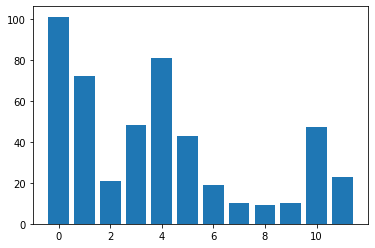

In [ ]:
from collections import Counter
from matplotlib import pyplot as plt

counter = Counter(y)
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
# View the percentages for each class
print("Class Representation in the original dataset:")
for target_class, value in counter.items():
	percentage = value / len(y) * 100
	print(' -Class=%s, n=%d (%.3f%%)' % (str(target_dict_rev[target_class]).zfill(5), value, percentage))

Class Representation in the original dataset:
 -Class=01110, n=101 (20.868%)
 -Class=11101, n=72 (14.876%)
 -Class=11001, n=21 (4.339%)
 -Class=11111, n=48 (9.917%)
 -Class=01100, n=81 (16.736%)
 -Class=01000, n=43 (8.884%)
 -Class=10001, n=19 (3.926%)
 -Class=00000, n=10 (2.066%)
 -Class=11011, n=9 (1.860%)
 -Class=00100, n=10 (2.066%)
 -Class=01010, n=47 (9.711%)
 -Class=10101, n=23 (4.752%)


####Applying SMOTE
We will now apply `SMOTE` to the data set. We will be using `SMOTE` that is provided in the `imblearn` python package. 

In [ ]:
from imblearn.over_sampling import SMOTE

X = modified_encoded_data.drop('target',axis="columns")
y = modified_encoded_data['target']

smote = SMOTE()
%time X, y = smote.fit_resample(X,y)

y = y.apply(lambda x: target_dict[x])

CPU times: user 14.3 ms, sys: 1.02 ms, total: 15.3 ms
Wall time: 15.1 ms


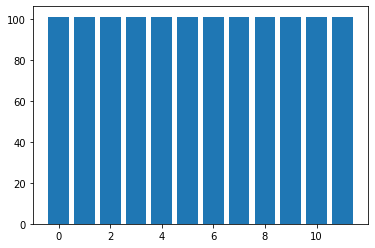

In [ ]:
counter = Counter(y)
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
# View the percentages for each class
print("Class Representation in the synthetic dataset:")
for target_class, value in counter.items():
	percentage = value / len(y) * 100
	print(' -Class=%s, n=%d (%.3f%%)' % (str(target_dict_rev[target_class]).zfill(5), value, percentage))

Class Representation in the synthetic dataset:
 -Class=01110, n=101 (8.333%)
 -Class=11101, n=101 (8.333%)
 -Class=11001, n=101 (8.333%)
 -Class=11111, n=101 (8.333%)
 -Class=01100, n=101 (8.333%)
 -Class=01000, n=101 (8.333%)
 -Class=10001, n=101 (8.333%)
 -Class=00000, n=101 (8.333%)
 -Class=11011, n=101 (8.333%)
 -Class=00100, n=101 (8.333%)
 -Class=01010, n=101 (8.333%)
 -Class=10101, n=101 (8.333%)


We now have a balanced dataset containing roughly the same proportion of each target value that we are interested in. We will recombine into one dataframe for now.

In [ ]:
# Recombine the X and y from smote
modified_encoded_data = pd.concat([X, y], axis=1)
modified_encoded_data

,age,sex_F,sex_M,faNoily_status_No,faNoily_status_Yes,religion_C,religion_M,religion_O,occupation_ARTISAN,occupation_C/SERVANT,...,Injury_No,Injury_Yes,Spiritual_consult_No,Spiritual_consult_Yes,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,target
0,18,0,1,0,1,1,0,0,0,0,...,1,0,0,1,0,1,1,1,0,0
1,22,0,1,0,1,1,0,0,0,0,...,1,0,0,1,1,1,1,0,1,1
2,35,0,1,1,0,0,1,0,1,0,...,1,0,0,1,1,1,0,0,1,2
3,30,0,1,0,1,0,1,0,1,0,...,1,0,0,1,1,1,1,1,1,3
4,86,1,0,0,1,1,0,0,0,0,...,1,0,0,1,0,1,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,17,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,3
1208,23,0,0,0,1,0,1,0,0,0,...,1,0,0,0,1,1,1,1,1,3
1209,39,0,0,0,1,0,0,0,0,0,...,1,0,0,1,1,1,1,1,1,3
1210,30,0,1,0,1,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,3


##Training and Testing the Machine Learning and Deep Learning Models
We can continue with our data and begin training. `modified_encoded_data` holds data that was created using SMOTE and `original_encoded_data` holds the original dataset. 

<br>

First we will train and test baseline models and then we will replicate the model that was built in the paper.

###Machine Learning Models
Here we will run some of the machine learning approaches that the paper ran in the experiment. We will construct and train a Multilayer Perceptron (MLP), Support Vector Machines (SVM), Random Forest (RF) and Decision Tree (DT) using the `sklearn` deep learning library. We will define all the models here as functions and will then call them for the balanced dataset and the imbalanced datasets.

####Functions for Each ML Model Used

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Function for MLP Classifier
def mlp(Xtrain, Xtest, ytrain, ytest):
  mlp_clf = MLPClassifier(activation='relu', random_state=42)
  mlp_clf.fit(Xtrain,ytrain)
  y_pred = mlp_clf.predict(Xtest)
  acc = accuracy_score(ytest,y_pred)
  print("MLP Accuracy:", acc)
  return acc

# Function for SVM Classifier
def svm(Xtrain, Xtest, ytrain, ytest):
  svc_clf = SVC(kernel='linear', random_state=42, cache_size=1500)
  svc_clf.fit(Xtrain,ytrain)
  y_pred = svc_clf.predict(Xtest)
  acc = accuracy_score(ytest,y_pred)
  print("SVM Accuracy:", acc)
  return acc

# Function for RF Classifier
def rf(Xtrain, Xtest, ytrain, ytest):
  rf_clf = RandomForestClassifier(random_state=42)
  rf_clf.fit(Xtrain,ytrain)
  y_pred = rf_clf.predict(Xtest)
  acc = accuracy_score(ytest,y_pred)
  print("RF Accuracy:", acc)
  return acc

# Function for DT Classifier
def dt(Xtrain, Xtest, ytrain, ytest):
  dt_clf = DecisionTreeClassifier(random_state=42)
  dt_clf.fit(Xtrain,ytrain)
  y_pred = dt_clf.predict(Xtest)
  acc = accuracy_score(ytest,y_pred)
  print("DT Accuracy:", acc)
  return acc


####ML Models With Imbalanced (Original) Dataset
ML models were used for both balanced and imbalanced datasets. To start off, we will use these classifiers with imbalanced data. The paper stated that during this phase, a train and test split was done with 80-20 ratio. To keep things consistent, we will also use a train/test split of 80-20.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Split apart X and y from the synthetic data
X_set = original_encoded_data.drop(target_cols_target, axis='columns')
y_set = original_encoded_data['target']

# Create 80-20 split like stated in the paper for all of the classifiers used
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_set, y_set, test_size=0.2)

# Print the shapes of each to see if they all match correctly
print("Imbalanced X_train.shape: ", X_train_original.shape)
print("Imbalanced X_test.shape: ", X_test_original.shape)
print("Imbalanced y_train.shape: ", y_train_original.shape)
print("Imbalanced y_test.shape: ", y_test_original.shape)

Imbalanced X_train.shape:  (400, 26)
Imbalanced X_test.shape:  (100, 26)
Imbalanced y_train.shape:  (400,)
Imbalanced y_test.shape:  (100,)


In [ ]:
mlp_acc_original, svm_acc_original, rf_acc_original, dt_acc_original = None, None, None, None
%time mlp_acc_original = mlp(X_train_original, X_test_original, y_train_original, y_test_original)
%time svm_acc_original = svm(X_train_original, X_test_original, y_train_original, y_test_original)
%time rf_acc_original = rf(X_train_original, X_test_original, y_train_original, y_test_original)
%time dt_acc_original = dt(X_train_original, X_test_original, y_train_original, y_test_original)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLP Accuracy: 0.38
CPU times: user 632 ms, sys: 530 ms, total: 1.16 s
Wall time: 643 ms
SVM Accuracy: 0.43
CPU times: user 182 ms, sys: 97.7 ms, total: 280 ms
Wall time: 177 ms
RF Accuracy: 0.26
CPU times: user 193 ms, sys: 5.72 ms, total: 199 ms
Wall time: 201 ms
DT Accuracy: 0.27
CPU times: user 7.56 ms, sys: 22 µs, total: 7.58 ms
Wall time: 7.05 ms


In [ ]:
print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 19.4


####ML Models With Balanced (Modified) Dataset
ML models were used for both balanced and imbalanced datasets. To start off, we will use these classifiers with imbalanced data. The paper stated that during this phase, a train and test split was done with 80-20 ratio. To keep things consistent, we will also use a train/test split of 80-20.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Split apart X and y from the synthetic data
X_set = modified_encoded_data.drop(target_cols_target, axis='columns')
y_set = modified_encoded_data['target']

# Create 80-20 split like stated in the paper for all of the classifiers used
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_set, y_set, test_size=0.2)

# Print the shapes of each to see if they all match correctly
print("Balanced X_train.shape: ", X_train_balanced.shape)
print("Balanced X_test.shape: ", X_test_balanced.shape)
print("Balanced y_train.shape: ", y_train_balanced.shape)
print("Balanced y_test.shape: ", y_test_balanced.shape)

Balanced X_train.shape:  (969, 26)
Balanced X_test.shape:  (243, 26)
Balanced y_train.shape:  (969,)
Balanced y_test.shape:  (243,)


In [ ]:
mlp_acc_balanced, svm_acc_balanced, rf_acc_balanced, dt_acc_balanced = None, None, None, None
%time mlp_acc_balanced = mlp(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced)
%time svm_acc_balanced = svm(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced)
%time rf_acc_balanced = rf(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced)
%time dt_acc_balanced = dt(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLP Accuracy: 0.588477366255144
CPU times: user 1.32 s, sys: 1.03 s, total: 2.36 s
Wall time: 1.23 s
SVM Accuracy: 0.6584362139917695
CPU times: user 330 ms, sys: 107 ms, total: 436 ms
Wall time: 321 ms
RF Accuracy: 0.6954732510288066
CPU times: user 208 ms, sys: 8.97 ms, total: 217 ms
Wall time: 216 ms
DT Accuracy: 0.6666666666666666
CPU times: user 6.43 ms, sys: 1.04 ms, total: 7.46 ms
Wall time: 7.2 ms


In [ ]:
print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 19.5


####Summary of the Accuracies

In [ ]:
print("======-Original Data Summary-======")
print(" MLP accuracy:", mlp_acc_original)
print(" SVM accuracy:", svm_acc_original)
print(" RF accuracy:", rf_acc_original)
print(" DT accuracy:", dt_acc_original)

print("\n====-Balanced Data Summary-====")
print(" MLP accuracy:", mlp_acc_balanced)
print(" SVM accuracy:", svm_acc_balanced)
print(" RF accuracy:", rf_acc_balanced)
print(" DT accuracy:", dt_acc_balanced)

======-Original Data Summary-======
 MLP accuracy: 0.38
 SVM accuracy: 0.43
 RF accuracy: 0.26
 DT accuracy: 0.27

====-Balanced Data Summary-====
 MLP accuracy: 0.588477366255144
 SVM accuracy: 0.6584362139917695
 RF accuracy: 0.6954732510288066
 DT accuracy: 0.6666666666666666


###Deep Neural Network Multilayer Perceptron
Here we will run the deep learning approach that the paper ran in the experiment. We will construct and train the Deep Neural Network Multilayer Perceptron (DNN-MLP) using the `Keras` deep learning API.



####The Model and Helper Functions
The model will be composed of the following:
*   An initial input layer
*   Three hidden layers with output dimensions 20, 20, 40 respectively
*   Dropout layers with `p = 0.2` after the first and second hidden layers
*   A final otuput layer with an output dimension of 5
*   ReLU activation for each of the hidden layers and Sigmoid for the output layer

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import np_utils

def Create_DNN_MLP(in_features):
  model = Sequential()
  model.add(Dense(15, input_shape=(in_features, ), activation="relu"))
  model.add(Dense(20, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(20, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(5, activation="sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
  return model

In [ ]:
def trainAndEval(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train, epochs=40, verbose=2)
  _, accuracy = model.evaluate(X_test, y_test, verbose=0)
  return accuracy

In [ ]:
# To get the parameter count we can view the summary of the model
Create_DNN_MLP(26).summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_219 (Dense)           (None, 15)                405       
                                                                 
 dense_220 (Dense)           (None, 20)                320       
                                                                 
 dropout_96 (Dropout)        (None, 20)                0         
                                                                 
 dense_221 (Dense)           (None, 20)                420       
                                                                 
 dropout_97 (Dropout)        (None, 20)                0         
                                                                 
 dense_222 (Dense)           (None, 40)                840       
                                                                 
 dense_223 (Dense)           (None, 5)               

####Train and Evaluate with Original Data
Like performed in the paper, train and test split is done as 70-30 unlike the ML models.

In [ ]:
X_set = original_encoded_data.drop(target_cols_target, axis='columns')
y_set = original_encoded_data[target_cols]

# Perform 70-30 split
X_train_dnn_original, X_test_dnn_original, y_train_dnn_original, y_test_dnn_original = train_test_split(X_set, y_set, test_size=0.3)

# Print the shapes of each to see if they all match correctly
print("Imbalanced X_train.shape: ", X_train_dnn_original.shape)
print("Imbalanced X_test.shape: ", X_test_dnn_original.shape)
print("Imbalanced y_train.shape: ", y_train_dnn_original.shape)
print("Imbalanced y_test.shape: ", y_test_dnn_original.shape)

Imbalanced X_train.shape:  (350, 26)
Imbalanced X_test.shape:  (150, 26)
Imbalanced y_train.shape:  (350, 5)
Imbalanced y_test.shape:  (150, 5)


In [ ]:
dnn_original_aucc = None
%time dnn_original_aucc = trainAndEval(Create_DNN_MLP(X_train_dnn_original.shape[1]), X_train_dnn_original, X_test_dnn_original, y_train_dnn_original, y_test_dnn_original)

Epoch 1/40
11/11 - 1s - loss: 0.9436 - accuracy: 0.3343 - 581ms/epoch - 53ms/step
Epoch 2/40
11/11 - 0s - loss: 0.7844 - accuracy: 0.3514 - 33ms/epoch - 3ms/step
Epoch 3/40
11/11 - 0s - loss: 0.7183 - accuracy: 0.4200 - 32ms/epoch - 3ms/step
Epoch 4/40
11/11 - 0s - loss: 0.7002 - accuracy: 0.3457 - 33ms/epoch - 3ms/step
Epoch 5/40
11/11 - 0s - loss: 0.6628 - accuracy: 0.3800 - 44ms/epoch - 4ms/step
Epoch 6/40
11/11 - 0s - loss: 0.6700 - accuracy: 0.3571 - 31ms/epoch - 3ms/step
Epoch 7/40
11/11 - 0s - loss: 0.6678 - accuracy: 0.4114 - 34ms/epoch - 3ms/step
Epoch 8/40
11/11 - 0s - loss: 0.6675 - accuracy: 0.4143 - 30ms/epoch - 3ms/step
Epoch 9/40
11/11 - 0s - loss: 0.6624 - accuracy: 0.4171 - 32ms/epoch - 3ms/step
Epoch 10/40
11/11 - 0s - loss: 0.6526 - accuracy: 0.4543 - 35ms/epoch - 3ms/step
Epoch 11/40
11/11 - 0s - loss: 0.6528 - accuracy: 0.4057 - 32ms/epoch - 3ms/step
Epoch 12/40
11/11 - 0s - loss: 0.6427 - accuracy: 0.4371 - 32ms/epoch - 3ms/step
Epoch 13/40
11/11 - 0s - loss: 0.63

####Train and Evaluate with Balanced Data
The train and test split here is also done as 70-30.

In [ ]:
X_set = modified_encoded_data.drop(target_cols_target, axis='columns')
y_set = modified_encoded_data[target_cols]

# Perform 70-30 split
X_train_dnn_balanced, X_test_dnn_balanced, y_train_dnn_balanced, y_test_dnn_balanced = train_test_split(X_set, y_set, test_size=0.3)

# Print the shapes of each to see if they all match correctly
print("Balanced X_train.shape: ", X_train_dnn_balanced.shape)
print("Balanced X_test.shape: ", X_test_dnn_balanced.shape)
print("Balanced y_train.shape: ", y_train_dnn_balanced.shape)
print("Balanced y_test.shape: ", y_test_dnn_balanced.shape)

Balanced X_train.shape:  (848, 26)
Balanced X_test.shape:  (364, 26)
Balanced y_train.shape:  (848, 5)
Balanced y_test.shape:  (364, 5)


In [ ]:
dnn_modified_aucc = None
%time dnn_modified_aucc = trainAndEval(Create_DNN_MLP(X_train_dnn_balanced.shape[1]), X_train_dnn_balanced, X_test_dnn_balanced, y_train_dnn_balanced, y_test_dnn_balanced)

Epoch 1/40
27/27 - 1s - loss: 0.9102 - accuracy: 0.1191 - 561ms/epoch - 21ms/step
Epoch 2/40
27/27 - 0s - loss: 0.6951 - accuracy: 0.3408 - 65ms/epoch - 2ms/step
Epoch 3/40
27/27 - 0s - loss: 0.6752 - accuracy: 0.3514 - 72ms/epoch - 3ms/step
Epoch 4/40
27/27 - 0s - loss: 0.6702 - accuracy: 0.3774 - 76ms/epoch - 3ms/step
Epoch 5/40
27/27 - 0s - loss: 0.6639 - accuracy: 0.3998 - 65ms/epoch - 2ms/step
Epoch 6/40
27/27 - 0s - loss: 0.6559 - accuracy: 0.4057 - 68ms/epoch - 3ms/step
Epoch 7/40
27/27 - 0s - loss: 0.6481 - accuracy: 0.4057 - 67ms/epoch - 2ms/step
Epoch 8/40
27/27 - 0s - loss: 0.6414 - accuracy: 0.4517 - 72ms/epoch - 3ms/step
Epoch 9/40
27/27 - 0s - loss: 0.6243 - accuracy: 0.4375 - 71ms/epoch - 3ms/step
Epoch 10/40
27/27 - 0s - loss: 0.6165 - accuracy: 0.4552 - 66ms/epoch - 2ms/step
Epoch 11/40
27/27 - 0s - loss: 0.6140 - accuracy: 0.4127 - 75ms/epoch - 3ms/step
Epoch 12/40
27/27 - 0s - loss: 0.6091 - accuracy: 0.5059 - 72ms/epoch - 3ms/step
Epoch 13/40
27/27 - 0s - loss: 0.60

####DNN-MLP Accuracy Summary

In [ ]:
print("====-DNN-MLP Accuracy Summary-====")
print(" With Original Data:", dnn_original_aucc)
print(" With Balanced Data:", dnn_modified_aucc)

====-DNN-MLP Accuracy Summary-====
 With Original Data: 0.7200000286102295
 With Balanced Data: 0.5302197933197021


##Ablation Study
For the ablation study, we will experiment with each of the full connected hidden layers. We will determine the performance in terms of accuracy using the balanced datasets only.

###Defining the Different Models

In [ ]:
# Removing the last hidden layer
def ABL1_DNN_MLP(in_features):
  model = Sequential()
  model.add(Dense(15, input_shape=(in_features, ), activation="relu"))
  model.add(Dense(20, activation='relu')) # Hidden 1
  model.add(Dropout(0.2))
  model.add(Dense(20, activation='relu')) # Hidden 2
  model.add(Dropout(0.2))
  #model.add(Dense(40, activation='relu')) # Hidden 3
  model.add(Dense(5, activation="sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# Removing the middle hidden layer
def ABL2_DNN_MLP(in_features):
  model = Sequential()
  model.add(Dense(15, input_shape=(in_features, ), activation="relu"))
  model.add(Dense(20, activation='relu')) # Hidden 1
  model.add(Dropout(0.2))
  #model.add(Dense(20, activation='relu')) # Hidden 2
  model.add(Dropout(0.2))
  model.add(Dense(40, activation='relu')) # Hidden 3
  model.add(Dense(5, activation="sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# Removing the first hidden layer
def ABL3_DNN_MLP(in_features):
  model = Sequential()
  model.add(Dense(15, input_shape=(in_features, ), activation="relu"))
  #model.add(Dense(20, activation='relu')) # Hidden 1
  model.add(Dropout(0.2))
  model.add(Dense(20, activation='relu')) # Hidden 2
  model.add(Dropout(0.2))
  model.add(Dense(40, activation='relu')) # Hidden 3
  model.add(Dense(5, activation="sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

###Training and Testing

In [ ]:
ABL1_Aucc = None
%time ABL1_Aucc = trainAndEval(ABL1_DNN_MLP(X_train_dnn_balanced.shape[1]), X_train_dnn_balanced, X_test_dnn_balanced, y_train_dnn_balanced, y_test_dnn_balanced)

Epoch 1/40
27/27 - 1s - loss: 1.1644 - accuracy: 0.1250 - 846ms/epoch - 31ms/step
Epoch 2/40
27/27 - 0s - loss: 0.8230 - accuracy: 0.2358 - 66ms/epoch - 2ms/step
Epoch 3/40
27/27 - 0s - loss: 0.7171 - accuracy: 0.2406 - 79ms/epoch - 3ms/step
Epoch 4/40
27/27 - 0s - loss: 0.6725 - accuracy: 0.2700 - 69ms/epoch - 3ms/step
Epoch 5/40
27/27 - 0s - loss: 0.6462 - accuracy: 0.3349 - 68ms/epoch - 3ms/step
Epoch 6/40
27/27 - 0s - loss: 0.6440 - accuracy: 0.3432 - 67ms/epoch - 2ms/step
Epoch 7/40
27/27 - 0s - loss: 0.6358 - accuracy: 0.3620 - 70ms/epoch - 3ms/step
Epoch 8/40
27/27 - 0s - loss: 0.6224 - accuracy: 0.3561 - 67ms/epoch - 2ms/step
Epoch 9/40
27/27 - 0s - loss: 0.6206 - accuracy: 0.3479 - 66ms/epoch - 2ms/step
Epoch 10/40
27/27 - 0s - loss: 0.6085 - accuracy: 0.3538 - 65ms/epoch - 2ms/step
Epoch 11/40
27/27 - 0s - loss: 0.6132 - accuracy: 0.3455 - 86ms/epoch - 3ms/step
Epoch 12/40
27/27 - 0s - loss: 0.6039 - accuracy: 0.3762 - 68ms/epoch - 3ms/step
Epoch 13/40
27/27 - 0s - loss: 0.60

In [ ]:
ABL2_Aucc = None
%time ABL2_Aucc = trainAndEval(ABL2_DNN_MLP(X_train_dnn_balanced.shape[1]), X_train_dnn_balanced, X_test_dnn_balanced, y_train_dnn_balanced, y_test_dnn_balanced)

Epoch 1/40
27/27 - 1s - loss: 0.8063 - accuracy: 0.1120 - 528ms/epoch - 20ms/step
Epoch 2/40
27/27 - 0s - loss: 0.6828 - accuracy: 0.2488 - 73ms/epoch - 3ms/step
Epoch 3/40
27/27 - 0s - loss: 0.6645 - accuracy: 0.3125 - 63ms/epoch - 2ms/step
Epoch 4/40
27/27 - 0s - loss: 0.6517 - accuracy: 0.3042 - 63ms/epoch - 2ms/step
Epoch 5/40
27/27 - 0s - loss: 0.6403 - accuracy: 0.4351 - 70ms/epoch - 3ms/step
Epoch 6/40
27/27 - 0s - loss: 0.6291 - accuracy: 0.4505 - 65ms/epoch - 2ms/step
Epoch 7/40
27/27 - 0s - loss: 0.6208 - accuracy: 0.4717 - 76ms/epoch - 3ms/step
Epoch 8/40
27/27 - 0s - loss: 0.6086 - accuracy: 0.5389 - 70ms/epoch - 3ms/step
Epoch 9/40
27/27 - 0s - loss: 0.5962 - accuracy: 0.5177 - 66ms/epoch - 2ms/step
Epoch 10/40
27/27 - 0s - loss: 0.5864 - accuracy: 0.5318 - 68ms/epoch - 3ms/step
Epoch 11/40
27/27 - 0s - loss: 0.5803 - accuracy: 0.5307 - 64ms/epoch - 2ms/step
Epoch 12/40
27/27 - 0s - loss: 0.5684 - accuracy: 0.4858 - 73ms/epoch - 3ms/step
Epoch 13/40
27/27 - 0s - loss: 0.56

In [ ]:
ABL3_Aucc = None
%time ABL3_Aucc = trainAndEval(ABL3_DNN_MLP(X_train_dnn_balanced.shape[1]), X_train_dnn_balanced, X_test_dnn_balanced, y_train_dnn_balanced, y_test_dnn_balanced)

Epoch 1/40
27/27 - 1s - loss: 0.9393 - accuracy: 0.1969 - 528ms/epoch - 20ms/step
Epoch 2/40
27/27 - 0s - loss: 0.7607 - accuracy: 0.2276 - 70ms/epoch - 3ms/step
Epoch 3/40
27/27 - 0s - loss: 0.6965 - accuracy: 0.2677 - 74ms/epoch - 3ms/step
Epoch 4/40
27/27 - 0s - loss: 0.6923 - accuracy: 0.3255 - 72ms/epoch - 3ms/step
Epoch 5/40
27/27 - 0s - loss: 0.6815 - accuracy: 0.3608 - 70ms/epoch - 3ms/step
Epoch 6/40
27/27 - 0s - loss: 0.6765 - accuracy: 0.3856 - 70ms/epoch - 3ms/step
Epoch 7/40
27/27 - 0s - loss: 0.6643 - accuracy: 0.3962 - 70ms/epoch - 3ms/step
Epoch 8/40
27/27 - 0s - loss: 0.6579 - accuracy: 0.4399 - 76ms/epoch - 3ms/step
Epoch 9/40
27/27 - 0s - loss: 0.6556 - accuracy: 0.4399 - 78ms/epoch - 3ms/step
Epoch 10/40
27/27 - 0s - loss: 0.6426 - accuracy: 0.4776 - 69ms/epoch - 3ms/step
Epoch 11/40
27/27 - 0s - loss: 0.6414 - accuracy: 0.4811 - 85ms/epoch - 3ms/step
Epoch 12/40
27/27 - 0s - loss: 0.6387 - accuracy: 0.4835 - 73ms/epoch - 3ms/step
Epoch 13/40
27/27 - 0s - loss: 0.63

###Summary of Accuracies

In [ ]:
print("=======-Ablation Study Accuracy Summary-=======")
print(" Model with 1st hidden layer removed:", ABL1_Aucc)
print(" Model with 2nd hidden layer removed:", ABL2_Aucc)
print(" Model with 3rd hidden layer removed:", ABL3_Aucc)

=======-Ablation Study Accuracy Summary-=======
 Model with 1st hidden layer removed: 0.4065934121608734
 Model with 2nd hidden layer removed: 0.45604395866394043
 Model with 3rd hidden layer removed: 0.3708791136741638


##Additional Experiments
As an additional experiement, we created our own model using `PyTorch`. This model will be used on both the imbalanced and balanced datasets used. The accuracies will then be compared with the DNN-MLP model that was created in the paper.


###Custom Dataset Class, and Additional Helper Functions
We will create our own custom dataset which will handle our data for our models.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, df, target_cols, target_cols_target):
    x = df.drop(target_cols_target,axis="columns")
    y = df[target_cols]

    self.x_train = torch.tensor(x.values ,dtype=torch.float)
    self.y_train = torch.tensor(y.values ,dtype=torch.float)

  def __len__(self):
    return len(self.y_train)
  
  def __getitem__(self,idx):
    return self.x_train[idx], self.y_train[idx]

In [ ]:
def load_data(train_dataset, val_dataset, batch_size):
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
  return train_loader, val_loader

In [ ]:
def eval_model(model, val_loader):
  model.eval()
  y_pred = torch.LongTensor()
  y_score = torch.Tensor()
  y_true = torch.LongTensor()
  model.eval()

  for x, y in val_loader:
    y_hat = model(x)
    y_score = torch.cat((y_score, y_hat), dim=0)
    y_hat = (y_hat > 0.5).int()
    y_pred = torch.cat((y_pred, y_hat), dim=0)
    y_true = torch.cat((y_true, y), dim=0)
  p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')
  roc_auc = roc_auc_score(y_true, y_score.detach().numpy())
  accuracy = accuracy_score(y_true, y_pred)
  return p, r, f, roc_auc, accuracy

In [ ]:
def train(model, train_loader, val_loader, n_epochs, optimizer, criterion, allowPrint = True):
  for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for x, y in train_loader:
      
      optimizer.zero_grad()
      outputs = model(x)

      loss = criterion(outputs, y)
      loss.backward()
      optimizer.step()
      
      train_loss += loss.item()
      train_loss = train_loss / len(train_loader)
      p, r, f, roc_auc, accuracy = eval_model(model, val_loader)
      
      if allowPrint:
        print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch+1, train_loss))
        print('Epoch: {} \t Validation p: {:.2f}, r:{:.2f}, f: {:.2f}, roc_auc:␣ {:.2f}, accuracy: {:.2f}'.format(epoch+1, p, r, f, roc_auc, accuracy))

###Our Model
Now we will define our own model. It will be composed of the following:

*   An input layer with dimensions (26,20)
*   Four inner fully connected layers
    - First hidden layer: Dimensions (20,40)
    - Second hidden layer: Dimensions (40,80)
    - Third hidden layer: Dimensions (80,100)
    - Fourth hidden layer: Dimensions (100,60)
*   Final output layer with dimension (60,5)
Each of the inner fully connected layers will have ReLU activation and a dropout performed on it. The input will also have a ReLU activation while the final output layer will have a sigmoid activation.

In [ ]:
class OUR_DNN(nn.Module):
  def __init__(self):
    super(OUR_DNN, self).__init__()
    self.input = nn.Linear(26, 20)
    self.fc1 = nn.Linear(20, 40)
    self.fc2 = nn.Linear(40, 80)
    self.fc3 = nn.Linear(80, 100)
    self.fc4 = nn.Linear(100, 60)
    self.out = nn.Linear(60, 5)
    self.dropout = nn.Dropout(0.2);

  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.relu(self.dropout(self.fc1(x)))
    x = F.relu(self.dropout(self.fc2(x)))
    x = F.relu((self.fc3(x)))
    x = F.relu((self.fc4(x)))
    return torch.sigmoid(self.out(x))

###Training and Evaluating Our Model
Both the imbalanced and balanced datasets will be used for this model. The data will similarly be split 70-30 for each.

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

####Train and Evaluate with Original Data

In [ ]:
# Get our Custom Dataset with the original data
dataset = CustomDataset(original_encoded_data, target_cols, target_cols_target)
batch_size = 32

# Split the datasets 70-30
split = int(len(dataset)*0.7)
lengths = [split, len(dataset) - split]
train_dataset, val_dataset = random_split(dataset, lengths)

# Print the shapes of each dataset
print("Length of train dataset:", len(train_dataset))
print("Length of val dataset:", len(val_dataset))

# Get our train and validation loaders
train_loader, val_loader = load_data(train_dataset, val_dataset, batch_size)

# Create our model
model = OUR_DNN()

Length of train dataset: 350
Length of val dataset: 150


In [ ]:
# Hyperparameters used
n_epochs = 40
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train(model, train_loader, val_loader, n_epochs, optimizer, criterion)

Epoch: 1 	 Training Loss: 0.063475
Epoch: 1 	 Validation p: 0.76, r:0.52, f: 0.62, roc_auc:␣ 0.46, accuracy: 0.09
Epoch: 1 	 Training Loss: 0.066397
Epoch: 1 	 Validation p: 0.77, r:0.51, f: 0.61, roc_auc:␣ 0.46, accuracy: 0.11
Epoch: 1 	 Training Loss: 0.067098
Epoch: 1 	 Validation p: 0.68, r:0.67, f: 0.67, roc_auc:␣ 0.46, accuracy: 0.01
Epoch: 1 	 Training Loss: 0.069159
Epoch: 1 	 Validation p: 0.71, r:0.66, f: 0.68, roc_auc:␣ 0.46, accuracy: 0.05
Epoch: 1 	 Training Loss: 0.063213
Epoch: 1 	 Validation p: 0.76, r:0.53, f: 0.62, roc_auc:␣ 0.46, accuracy: 0.11
Epoch: 1 	 Training Loss: 0.061744
Epoch: 1 	 Validation p: 0.77, r:0.51, f: 0.61, roc_auc:␣ 0.41, accuracy: 0.11
Epoch: 1 	 Training Loss: 0.064791
Epoch: 1 	 Validation p: 0.77, r:0.51, f: 0.61, roc_auc:␣ 0.36, accuracy: 0.11
Epoch: 1 	 Training Loss: 0.062046
Epoch: 1 	 Validation p: 0.77, r:0.51, f: 0.61, roc_auc:␣ 0.36, accuracy: 0.11
Epoch: 1 	 Training Loss: 0.063695
Epoch: 1 	 Validation p: 0.77, r:0.51, f: 0.61, roc_a

In [ ]:
# Evaluate our accuracy
p, r, f, roc_auc_original, accuracy_original = eval_model(model, val_loader)

####Train and Evaluate with Balanced Data

In [ ]:
# Get our Custom Dataset with the original data
dataset = CustomDataset(modified_encoded_data, target_cols, target_cols_target)
batch_size = 32

# Split the datasets 70-30
split = int(len(dataset)*0.7)
lengths = [split, len(dataset) - split]
train_dataset, val_dataset = random_split(dataset, lengths)

# Print the shapes of each dataset
print("Length of train dataset:", len(train_dataset))
print("Length of val dataset:", len(val_dataset))

# Get our train and validation loaders
train_loader, val_loader = load_data(train_dataset, val_dataset, batch_size)

# Create our model
model = OUR_DNN()

Length of train dataset: 848
Length of val dataset: 364


In [ ]:
# Hyperparameters used
n_epochs = 40
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train(model, train_loader, val_loader, n_epochs, optimizer, criterion)

Epoch: 1 	 Training Loss: 0.025877
Epoch: 1 	 Validation p: 0.58, r:0.59, f: 0.58, roc_auc:␣ 0.57, accuracy: 0.00
Epoch: 1 	 Training Loss: 0.026384
Epoch: 1 	 Validation p: 0.56, r:0.64, f: 0.60, roc_auc:␣ 0.73, accuracy: 0.06
Epoch: 1 	 Training Loss: 0.025753
Epoch: 1 	 Validation p: 0.55, r:0.50, f: 0.52, roc_auc:␣ 0.73, accuracy: 0.11
Epoch: 1 	 Training Loss: 0.027531
Epoch: 1 	 Validation p: 0.56, r:0.66, f: 0.60, roc_auc:␣ 0.73, accuracy: 0.08
Epoch: 1 	 Training Loss: 0.025415
Epoch: 1 	 Validation p: 0.57, r:0.63, f: 0.60, roc_auc:␣ 0.57, accuracy: 0.06
Epoch: 1 	 Training Loss: 0.025648
Epoch: 1 	 Validation p: 0.58, r:0.71, f: 0.64, roc_auc:␣ 0.57, accuracy: 0.07
Epoch: 1 	 Training Loss: 0.025321
Epoch: 1 	 Validation p: 0.57, r:0.80, f: 0.66, roc_auc:␣ 0.57, accuracy: 0.07
Epoch: 1 	 Training Loss: 0.026196
Epoch: 1 	 Validation p: 0.56, r:0.83, f: 0.67, roc_auc:␣ 0.61, accuracy: 0.08
Epoch: 1 	 Training Loss: 0.024638
Epoch: 1 	 Validation p: 0.56, r:0.84, f: 0.67, roc_a

In [ ]:
# Evaluate our accuracy
p, r, f, roc_auc_modified, accuracy_modified = eval_model(model, val_loader)

###Our Model's ROC AUC and Accuracy Summary

In [ ]:
print("=====-Our DNN ROC AUC Summary-====")
print(" With Original Data:", roc_auc_original)
print(" With Balanced Data:", roc_auc_modified)

print("\n====-Our DNN Accuracy Summary-====")
print(" With Original Data:", accuracy_original)
print(" With Balanced Data:", accuracy_modified)

=====-Our DNN ROC AUC Summary-====
 With Original Data: 0.7724725104614535
 With Balanced Data: 0.866218301539791

====-Our DNN Accuracy Summary-====
 With Original Data: 0.3333333333333333
 With Balanced Data: 0.45054945054945056


In [ ]:
# We can get the number of parameters using the following
sum(p.numel() for p in model.parameters() if p.requires_grad)

19125

# References

[[1]](https://www.sciencedirect.com/science/article/pii/S2352914821000356) Israel Elujide, Stephen G. Fashoto, Bunmi Fashoto, Elliot Mbunge, Sakinat O. Folorunso, and Jeremiah O. Olamijuwon. 2021. Application of deep and machine learning techniques for multilabel classification performance on psychotic disorder diseases. Informatics in Medicine Unlocked, 23:100545

[[2]](https://www.sciencedirect.com/science/article/pii/S2352340917303487)  O Adejumo Adebowale, Nehemiah A Ikoba, Suleiman Esivue A, Okagbue Hilary I, Oguntunde Pelumi E, Odetunmibi Oluwole A, Job Obalowu. Quantitative exploration of factors influencing psychotic disorder ailments in Nigeria. Data in Brief 2017;14:175–85.